# Predict Yelp Ratings!

# 1. Introduction

Yelp data contains customers' reviews reflecting thier experience at a restaurant, like how they feel about foods, service or environment, and some other basic information of a certain restaurant, like location and categories. In this project, our group tried to come up with a simple, robust and accurate but imterpretable method to estimate yelp ratings. 

**Thesis Statement**: A regularized logistic regression model is a fast and accurate classfier. To predict Yelp ratings based on 1.5 million train data, a L2-regularized logistic classfier spends less than 3 minutes on trainning and yields rmse=0.63.

# 2. Data pre-processing


## 2.1 Cleanning texts

Step 1: Only keep words and several punctuations(.?!',) from the raw data(including train data and test data).

Step 2: Put all the words(about 0.4 million) in a huge dictionary and remove those words with frequency less than 250. Then we get a dictionary with only 16k words.

Step 3: Generate new words by combining "not" with the first adjective and verb appear behind it in current sentence. eg?

## 2.2 Special punctuations and category variable

We keep special punctuations who exist in a form of "..", "!!" or "??" by counting how many times they appear in one observation. No matter how many dots, question marks or exclamation marks appear together in one sentence, they will be counted as once. 

From star histograms of different categories, we find that categories have effects on ratings. So here we generate a sparse matrix for categories, and combine it to our original sparse matrix we generate for text.

# 3 Regularized Logistic Regreesion as a classifier


## 3.1 TFIDF: Term Frequency–Inverse Document Frequency

TFIDF is a numerical statistic that is intended to reflect how important a word is to a text (or say a sentence). The goal of using TFIDF instead of the raw frequencies of occurrence of a word in a text is to scale down the impact of word with high frequency in the corpus. The formula is: (w, t represent a word and a text)
$$\text{TF}(w,t) = \cfrac{\# w\ \text{in}\ t}{\text{#words in}\ t}, \quad \text{IDF}(w,t) = \log\cfrac{\text{#words in}\ t}{\text{#texts that contain}\ w}, \quad \text{TFIDF} = \text{TF} \times \text{IDF}$$

A constant 1 is added to the denominator and numerator to prevent zero divisions. After calculating the TFIDF for a text, the vector will be normalized . An example is shown below, suppose the corpus is composed of "This is not good", "This is delicious", and "Good".

\begin{equation}
\begin{pmatrix} 
1 & 1 & 1 & 1 & 0 \\
1 & 1 & 0 & 0 & 1 \\
0 & 0 & 0 & 1 & 0
\end{pmatrix} \Longrightarrow 
\begin{pmatrix} 
0.46 & 0.46 & 0.60 & 0.46 & 0 \\
0.52 & 0.52 & 0 & 0 & 0.68 \\
0 & 0 & 0 & 1 & 0
\end{pmatrix}
\end{equation}

The columns represent 'this''is''not''good''delicious' in proper order. We can see that 'not','delicious' and 'good' have the largest TFIDF within each text. Basically, higher TFIDF means higher importance.

## 3.2 Model fitting

First, we use cleaned data to build a large sparse matrix whose columns represent words  values are TFIDF. Then we build another sparse matrix whose columns represent categories and values are TFIDF. We combine them and get a sparse matrix with dimenson $1546379\times 17154$. This is the model matrix we will use in the following regularized logistic model. Let $p_i$ denote the probability of an $i$ stars rating, $m$ denote the number of texts, $n$ denote the number of unique words:

$$\text{P}(Y_i=k) = \cfrac{\exp({\mathbf{X}_i\beta_k})}{1+\sum_{k=1}^4\exp({\mathbf{X}_i\beta_k})}, \ k=1,2,3,4, \quad \text{P}(Y_i=5) = \cfrac{1}{1+\sum_{k=1}^4\exp({\mathbf{X}_i\beta_k})}$$

$$\text{Cost function}:\quad J(\beta) = -\cfrac{1}{m}\Big[\sum_{i=1}^{m}\sum_{j=1}^{5}\mathbf{1}_{\{Y_i=j\}}\log\text{P}(Y_i=j)\Big] + \cfrac{\lambda}{2}\sum_{k=1}^{5}\sum_{j=1}^{n}\beta_{kj}^2$$

A L-2 regularization term was added into the cost function. Defazio, A. et al. (2014) proposed a fast incremental gradient method called SAGA to solve this optimization problem. In our model, $m=1546379$ and $n=17154$. But it only costs 3 minutes to train the model.

Before fitting a model, we need to tune the $\lambda$:

**1/$\lambda$**|1|1.5|2|2.2|2.5|3
:-----:|:-----:|:-----:|:-----:
**MSE on validation set**|0.4300|0.4271|0.4262|0.4261|0.4262|0.4266

In [1]:
%run "./code/logit-saga.py"

Time spent on training model: 0:02:49.709520


## 3.3 Result

**rMSE: 0.63**

Based on the coefficients in the model, we find positive and negative words:

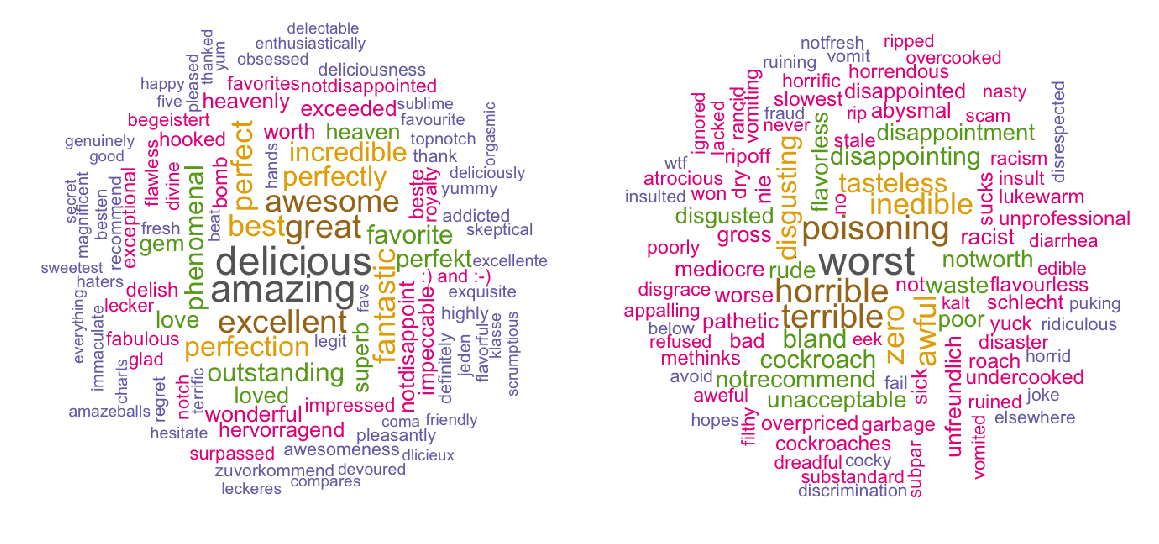

In [9]:
%run "code/print_picture.py"

# 4 Neural Network


## 4.1 Word embedding

Word embedding it to map words or phrases to vectors of real numbers with fixed dimension. A common way to map words is trainning a shallow neural network. After mapping, we can find most similar word of a given word, and which word does not match in a sentence. Here are some examples: 
- **amazing** is most similar to awesome
- **waitress** = waiter + woman - man
- **hotdog** doesn't match in "He is a very gentle hotdog".

In [ ]:
%run "./code/word2vec.py"
print(wv.most_similar(positive=['awesome'])[0][0])
print(wv.most_similar(positive=['waiter','woman'], negative=['man'])[0][0])
print(wv.doesnt_match("He is a very gentle hotdog".split()))

amazing is most similar to awesome
waitress = waiter + women - man
hotdog


## 4.2 FastText

Once we have those vectors that represent words, we can train a neural network to do supervised classification. FastText is an open-source library for text classification and representation provided by Facebook research. 
Different parameter gives different rMSE:

**1/$\lambda$**|1|1.5|2|2.2|2.5|3
:-----:|:-----:|:-----:|:-----:
**MSE on validation set**|0.4300|0.4271|0.4262|0.4261|0.4262|0.4266

## 4.3 Result

Based on prior knowledge of bodyfat, we think linear model is an appropriate model in this analysis. In order to achieve the goal of coming up with a simple, robust, and accurate “rule-of-thumb” method, we try to fit a multiple linear model. However, 14 variables seem to be too much in practice. We use different methods to do variable selection, and compare their performances.

Before modeling, we randomly choose 200 data as train set, and leave the rest as validation set. All the models are based on train set only, and tested on the validation set to check performance. 

Our goal is to find a model that is
* *accurate*: predict well on both test and validation data.
* *able to interprete*: easy to see which bunch of words have larger efficients in our logistic model.

Lasso is another approach to select variables. The advantage of this method is that we can minimize the MSE on the validation set. 

The model is still a linear model: 
$$ \text{(Body Fat %)}_i = \beta_0 + \beta_1x_1 + \dots + \beta_p x_p$$

However, instead of minimizing $\sum\limits_{i=1}^N (y_i-\beta_0-\beta_1x_i - \dots - \beta_px_p)^2$, which is what multiple linear regression does, Lasso minimizes:

$$\sum\limits_{i=1}^N (y_i-\beta_0-\beta_1x_i - \dots - \beta_px_p)^2 +\lambda \left|\sum\limits_{j=1}^p \beta_j \right| $$

We try different $\lambda^{(k)}$ to fit on the train set, then get coefficients $\beta^{(k)} = (\beta_0, \beta_1, \dots, \beta_{14})^{(k)}$. Then we get a predictive equation $y = X^\text{T}\beta^{(k)}$ to predict the BodyFat% on the validation set. The figure below shows the result of Lasso method.

**Explanation**:
* The x-axis indicates $\log \lambda$, and y-axis indicates MSE. 
* The numbers 0,1,...,14 in the label indicates the number of variables selected in that case. As $\lambda$ increases, the number of variables selected decreases. 
* The grey verticle lines indicates where some variables are deleted.

Based on the result, we choose $\lambda$ to be 0.1824 (the highlighted point in the figure), because:
* It select only 4 variables. The model is *simple*.
* The MSE at this time is relatively small (around 15). The model is *accurate*.

# 5. Conclusion

Based on the two different methods discussed before, we can propose two linear models to predict body fat %:

$$
\begin{align} 
\text{(BodyFat %)} &= -23.794+0.852*\text{Abdomen}-1.258*\text{Wrist}-0.073*\text{Weight} \\
\text{(BodyFat %)} &= -8.087+0.662*\text{Abdomen}-1.242*\text{Wrist}-0.186*\text{Height}+0.033*\text{Age}
\end{align}
$$

The MSE for these two models are sepearately: 13.99, 14.32. Because the first model is simpler and more accurate, we prefer the first predictive equation.

**Possible rule of thumb**: "Your abdomen circumference (cm) multiply by 0.85 minus wrist circumference (cm) multiply by 1.26 minus weight (lbs) multiply by 0.07 minus 24"

**Example Usage**: For a normal graduate male student, with circumferences: Abdomen=85cm, Wrist=18cm, Weight=130lbs, his  predicted body fat percentage would be around 16.43%. A 95% probability that his body fat is between 8.26% and 24.59%.

**Strengths**
- Our method is fast using less than 10 minutes, comparing several hours using by neural network.
- The final model is easy to understand.

**Weakness**

- RMSE is good, but not so small as multi-leyer neural network.
- Can not eliminate multicollinearity, which might miss some information.


## Reference

[1] Scikit-learn. Retrieved March 13, 2018, from http://scikit-learn.org/stable/index.html

[2] Facebookresearch/fastText. Retrieved March 13, 2018, from https://github.com/facebookresearch/fastText


## Contributions
* **Shiwei Cao**: Summary writing
* **Jiyun Chen**: Coding
* **Jing Guo**: Slides, summary writing